<div class='heading'>
    <div style='float:left;'><h1>CPSC 4300/6300: Applied Data Science</h1></div>
    <img style="float: right; padding-right: 10px; width: 65px" src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/clemson_paw.png"> </div>


## Week 13: Convolutional Neural Networks

**Clemson University**<br>
**Spring 2023**<br>
**Instructor(s):** Nina Hubig <br>

---

In [17]:
""" RUN THIS CELL TO GET THE RIGHT FORMATTING """
import requests
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/css/cpsc6300.css'
styles = requests.get(css_file).text
HTML(styles)

The goal of this lab is to introduce you to the basics of convolutional neural networks.

Goals:
- Load data from the CIFAR-10 dataset using Keras
- Build a convolutional neural network
- Train the network
- Test the network
- Explore the impact of different parameters

**Note:** This lab may require more processing power than previous labs. If needed, consider using Google Colaboratory to run the code.

#### Import packages and check the version of your TensorFlow, it should be the version >2.0.0

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D

In [19]:
print(tf.__version__)

2.12.0


---------
## 1. Download and prepare the CIFAR-10 dataset
The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.


In [20]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

#### Verify the data
To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:

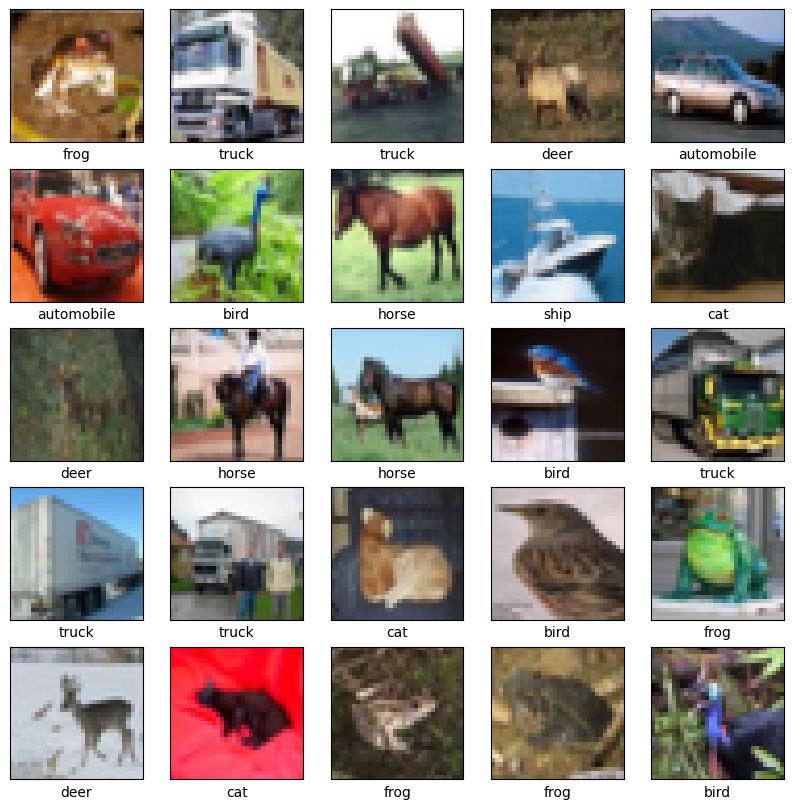

In [21]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()


## 2. Create the convolutional base
The 6 lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument input_shape to your first layer.

In [22]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the architecture of the model so far:

In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-trai

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically, as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

#### Add Dense layers on top
To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [24]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

Here's the complete architecture of your model:

In [25]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_3 (Flatten)         (None, 1024)             

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

#### Compile and train the model

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 38s 24ms/step - loss: 1.4921 - accuracy: 0.4592 - val_loss: 1.1996 - val_accuracy: 0.5772
Epoch 2/10
1563/1563 [==============================] - 35s 23ms/step - loss: 1.1174 - accuracy: 0.6022 - val_loss: 1.0668 - val_accuracy: 0.6254
Epoch 3/10
1563/1563 [==============================] - 36s 23ms/step - loss: 0.9742 - accuracy: 0.6570 - val_loss: 0.9557 - val_accuracy: 0.6685
Epoch 4/10
1563/1563 [==============================] - 39s 25ms/step - loss: 0.8787 - accuracy: 0.6904 - val_loss: 0.9446 - val_accuracy: 0.6719
Epoch 5/10
1563/1563 [==============================] - 38s 24ms/step - loss: 0.8074 - accuracy: 0.7159 - val_loss: 0.8944 - val_accuracy: 0.6902
Epoch 6/10
1563/1563 [==============================] - 38s 24ms/step - loss: 0.7454 - accuracy: 0.7392 - val_loss: 0.9252 - val_accuracy: 0.6874
Epoch 7/10
1563/1563 [==============================] - 38s 24ms/step - loss: 0.6955 - accuracy: 0.7563 - val_loss: 0.8577 -

#### Evaluate the model

313/313 - 1s - loss: 0.9524 - accuracy: 0.6981 - 1s/epoch - 4ms/step


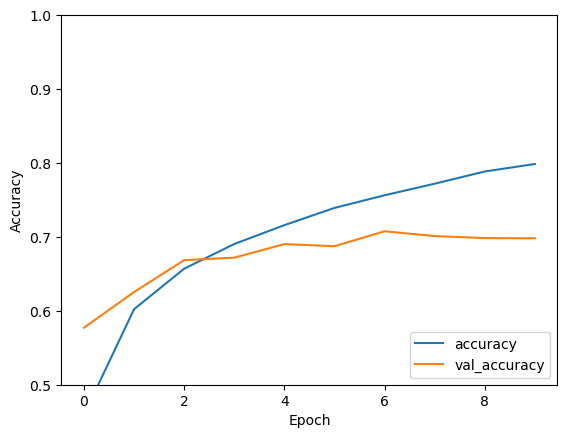

In [27]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [28]:
print(test_acc)

0.6980999708175659


In [ ]:
len(tf.config.list_physical_devices('GPU'))

Your simple CNN has achieved a test accuracy of over 70%. Not bad for a few lines of code!

<div class="exercise"><b>Exercise</b></div>

* List at least 3 parameters that could be tuned to improve the accuracy of your model.
* Pick at least one of those parameter and modify it. If you choose to change multiple parameters, I recommend changing one at a time. This will allow you to see the impact of each parameter changed a little more clearly.
* How does the accuracy of your model change? 
* What could be the reason for this change? Really think about the reasoning.

You can modify the network either in a new cell below or in the cells above. Just be sure that the modified code is included in the notebook before you submit it. Record both the original accuracy and the new accuracy with your other responses below.

<b>ANSWERS -</b><br>
The 3 parameters could be -

<b>Number of Convolutional Layers: </b><br>
The number of convolutional layers can be increased or decreased to find the optimal number for the given dataset. Adding more convolutional layers may help the model learn more complex features, while reducing the number of convolutional layers may prevent overfitting.

In [29]:


model1 = models.Sequential()
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model1.add(MaxPooling2D((2, 2), padding='same'))
model1.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model1.add(MaxPooling2D((2, 2), padding='same'))
model1.add(layers.Flatten())
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(10, activation='softmax'))

model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 6, 6, 128)         73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 3, 3, 128)       

In [30]:
model11 = models.Sequential()
model11.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model11.add(MaxPooling2D((2, 2)))
model11.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model11.add(MaxPooling2D((2, 2), padding='same'))
model11.add(layers.Flatten())
model11.add(layers.Dense(64, activation='relu'))
model11.add(layers.Dense(10, activation='softmax'))

model11.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 15, 15, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 4096)              0         
                                                                 
 dense_10 (Dense)            (None, 64)               

In [31]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history1 = model1.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 36s 23ms/step - loss: 1.4817 - accuracy: 0.4577 - val_loss: 1.2035 - val_accuracy: 0.5671
Epoch 2/10
1563/1563 [==============================] - 37s 24ms/step - loss: 1.0548 - accuracy: 0.6272 - val_loss: 0.9614 - val_accuracy: 0.6644
Epoch 3/10
1563/1563 [==============================] - 34s 22ms/step - loss: 0.8454 - accuracy: 0.7042 - val_loss: 0.8813 - val_accuracy: 0.6996
Epoch 4/10
1563/1563 [==============================] - 35s 23ms/step - loss: 0.7057 - accuracy: 0.7526 - val_loss: 0.8322 - val_accuracy: 0.7099
Epoch 5/10
1563/1563 [==============================] - 36s 23ms/step - loss: 0.5999 - accuracy: 0.7894 - val_loss: 0.8667 - val_accuracy: 0.7105
Epoch 6/10
1563/1563 [==============================] - 39s 25ms/step - loss: 0.5045 - accuracy: 0.8238 - val_loss: 0.8449 - val_accuracy: 0.7265
Epoch 7/10
1563/1563 [==============================] - 39s 25ms/step - loss: 0.4191 - accuracy: 0.8534 - val_loss: 0.8743 -

In [32]:
model11.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history11 = model11.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 29s 18ms/step - loss: 1.3912 - accuracy: 0.5050 - val_loss: 1.1537 - val_accuracy: 0.5854
Epoch 2/10
1563/1563 [==============================] - 28s 18ms/step - loss: 1.0235 - accuracy: 0.6415 - val_loss: 0.9747 - val_accuracy: 0.6579
Epoch 3/10
1563/1563 [==============================] - 28s 18ms/step - loss: 0.8906 - accuracy: 0.6873 - val_loss: 0.9479 - val_accuracy: 0.6700
Epoch 4/10
1563/1563 [==============================] - 29s 18ms/step - loss: 0.7958 - accuracy: 0.7232 - val_loss: 0.9017 - val_accuracy: 0.6800
Epoch 5/10
1563/1563 [==============================] - 28s 18ms/step - loss: 0.7205 - accuracy: 0.7488 - val_loss: 0.8731 - val_accuracy: 0.6954
Epoch 6/10
1563/1563 [==============================] - 29s 18ms/step - loss: 0.6494 - accuracy: 0.7732 - val_loss: 0.9003 - val_accuracy: 0.6991
Epoch 7/10
1563/1563 [==============================] - 27s 17ms/step - loss: 0.5944 - accuracy: 0.7928 - val_loss: 0.8561 -

313/313 - 3s - loss: 1.1995 - accuracy: 0.7141 - 3s/epoch - 9ms/step
313/313 - 2s - loss: 0.9504 - accuracy: 0.7014 - 2s/epoch - 8ms/step


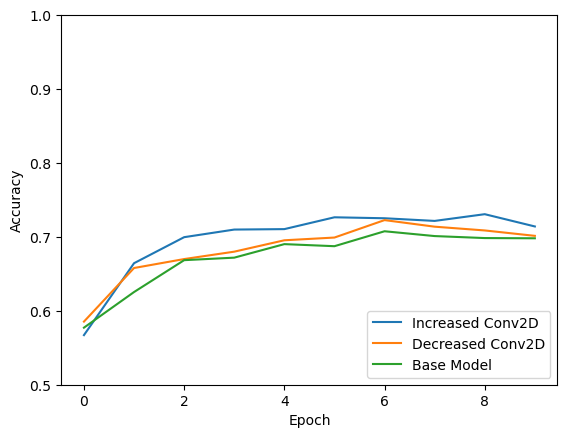

In [33]:
plt.plot(history1.history['val_accuracy'], label='Increased Conv2D')
plt.plot(history11.history['val_accuracy'], label='Decreased Conv2D')
plt.plot(history.history['val_accuracy'], label = 'Base Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss1, test_acc1 = model1.evaluate(test_images,  test_labels, verbose=2)
test_loss11, test_acc11 = model11.evaluate(test_images,  test_labels, verbose=2)

In [34]:
print('TEST ACCURACY')
print(f'Increased Conv2D Model Accuracy --> {test_acc1:.2f}%\nDecreased Conv2D Model Accuracy --> {test_acc11:.2f}%\nBase Model Accuracy --> {test_acc:.2f}%')

TEST ACCURACY
Increased Conv2D Model Accuracy --> 0.71%
Decreased Conv2D Model Accuracy --> 0.70%
Base Model Accuracy --> 0.70%


<b>Filter Size: </b><br>
The filter size can also be increased or decreased to find the optimal size for the given dataset. Increasing the filter size may help the model capture more information from the input image, while decreasing the filter size may increase the model's sensitivity to fine details.

In [35]:
model2 = models.Sequential()
model2.add(Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 3)))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(64, (5, 5), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Conv2D(128, (5, 5), activation='relu'))
model2.add(MaxPooling2D((2, 2), padding='same'))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(10, activation='softmax'))

model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 10, 10, 64)        51264     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 1, 1, 128)         204928    
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 1, 1, 128)       

In [36]:
model21 = models.Sequential()
model21.add(Conv2D(32, (1, 1), activation='relu', input_shape=(32, 32, 3)))
model21.add(MaxPooling2D((2, 2)))
model21.add(Conv2D(64, (1, 1), activation='relu'))
model21.add(MaxPooling2D((2, 2)))
model21.add(Conv2D(128, (1, 1), activation='relu'))
model21.add(MaxPooling2D((2, 2), padding='same'))
model21.add(layers.Flatten())
model21.add(layers.Dense(64, activation='relu'))
model21.add(layers.Dense(10, activation='softmax'))

model21.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 32, 32, 32)        128       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 16, 16, 64)        2112      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 8, 8, 128)         8320      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 4, 4, 128)       

In [37]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history2 = model2.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 27s 17ms/step - loss: 1.4968 - accuracy: 0.4550 - val_loss: 1.2819 - val_accuracy: 0.5465
Epoch 2/10
1563/1563 [==============================] - 26s 17ms/step - loss: 1.1555 - accuracy: 0.5898 - val_loss: 1.1392 - val_accuracy: 0.5889
Epoch 3/10
1563/1563 [==============================] - 26s 16ms/step - loss: 1.0023 - accuracy: 0.6478 - val_loss: 1.0134 - val_accuracy: 0.6458
Epoch 4/10
1563/1563 [==============================] - 25s 16ms/step - loss: 0.8969 - accuracy: 0.6851 - val_loss: 0.9778 - val_accuracy: 0.6611
Epoch 5/10
1563/1563 [==============================] - 25s 16ms/step - loss: 0.8136 - accuracy: 0.7160 - val_loss: 0.9445 - val_accuracy: 0.6750
Epoch 6/10
1563/1563 [==============================] - 26s 17ms/step - loss: 0.7521 - accuracy: 0.7355 - val_loss: 0.9673 - val_accuracy: 0.6700
Epoch 7/10
1563/1563 [==============================] - 25s 16ms/step - loss: 0.6936 - accuracy: 0.7575 - val_loss: 0.9803 -

In [38]:
model21.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history21 = model21.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.6950 - accuracy: 0.3915 - val_loss: 1.4993 - val_accuracy: 0.4593
Epoch 2/10
1563/1563 [==============================] - 21s 13ms/step - loss: 1.4483 - accuracy: 0.4836 - val_loss: 1.3740 - val_accuracy: 0.5078
Epoch 3/10
1563/1563 [==============================] - 20s 13ms/step - loss: 1.3668 - accuracy: 0.5134 - val_loss: 1.3245 - val_accuracy: 0.5332
Epoch 4/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.3179 - accuracy: 0.5324 - val_loss: 1.2949 - val_accuracy: 0.5372
Epoch 5/10
1563/1563 [==============================] - 26s 16ms/step - loss: 1.2763 - accuracy: 0.5487 - val_loss: 1.2911 - val_accuracy: 0.5420
Epoch 6/10
1563/1563 [==============================] - 24s 15ms/step - loss: 1.2434 - accuracy: 0.5609 - val_loss: 1.2389 - val_accuracy: 0.5558
Epoch 7/10
1563/1563 [==============================] - 24s 15ms/step - loss: 1.2132 - accuracy: 0.5707 - val_loss: 1.2463 -

313/313 - 2s - loss: 1.0349 - accuracy: 0.6794 - 2s/epoch - 6ms/step
313/313 - 2s - loss: 1.2004 - accuracy: 0.5715 - 2s/epoch - 5ms/step


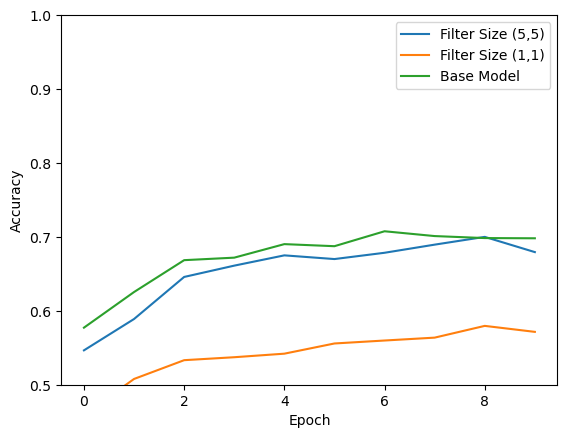

In [39]:
plt.plot(history2.history['val_accuracy'], label='Filter Size (5,5)')
plt.plot(history21.history['val_accuracy'], label='Filter Size (1,1)')
plt.plot(history.history['val_accuracy'], label = 'Base Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend()

test_loss2, test_acc2 = model2.evaluate(test_images,  test_labels, verbose=2)
test_loss21, test_acc21 = model21.evaluate(test_images,  test_labels, verbose=2)

In [40]:
print("TEST ACCURACY")
print(f'Filter Size (5,5) Model Accuracy --> {test_acc2:.2f}%\nFilter Size (1,1) Model Accuracy --> {test_acc21:.2f}%\nBase Model Accuracy --> {test_acc:.2f}%')

TEST ACCURACY
Filter Size (5,5) Model Accuracy --> 0.68%
Filter Size (1,1) Model Accuracy --> 0.57%
Base Model Accuracy --> 0.70%


<b>Learning Rate: </b><br>
The learning rate determines how quickly the model learns from the data. A smaller learning rate may lead to slower but more accurate learning, while a larger learning rate may lead to faster but less accurate learning. Tuning the learning rate can help find the optimal balance between speed and accuracy for the given dataset.

In [41]:
model3 = models.Sequential()
model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(64, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(128, (3, 3), activation='relu'))
model3.add(MaxPooling2D((2, 2)))
model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(10, activation='softmax'))

model3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 2, 2, 128)       

In [42]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.0001)
model3.compile(optimizer=adam,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history3 = model3.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

test_loss3, test_acc3 = model3.evaluate(test_images,  test_labels, verbose=2)

Epoch 1/10
1563/1563 [==============================] - 23s 14ms/step - loss: 1.8256 - accuracy: 0.3292 - val_loss: 1.5936 - val_accuracy: 0.4271
Epoch 2/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.5175 - accuracy: 0.4528 - val_loss: 1.4527 - val_accuracy: 0.4824
Epoch 3/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.4071 - accuracy: 0.4972 - val_loss: 1.3575 - val_accuracy: 0.5127
Epoch 4/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.3269 - accuracy: 0.5299 - val_loss: 1.3135 - val_accuracy: 0.5253
Epoch 5/10
1563/1563 [==============================] - 25s 16ms/step - loss: 1.2724 - accuracy: 0.5514 - val_loss: 1.2696 - val_accuracy: 0.5462
Epoch 6/10
1563/1563 [==============================] - 25s 16ms/step - loss: 1.2212 - accuracy: 0.5705 - val_loss: 1.2049 - val_accuracy: 0.5733
Epoch 7/10
1563/1563 [==============================] - 26s 17ms/step - loss: 1.1796 - accuracy: 0.5872 - val_loss: 1.2176 -

In [43]:
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=1)
model3.compile(optimizer=adam,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history31 = model3.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 24s 15ms/step - loss: 768838.3125 - accuracy: 0.0994 - val_loss: 2.3654 - val_accuracy: 0.1000
Epoch 2/10
1563/1563 [==============================] - 24s 15ms/step - loss: 2.4160 - accuracy: 0.1024 - val_loss: 2.3264 - val_accuracy: 0.1000
Epoch 3/10
1563/1563 [==============================] - 24s 15ms/step - loss: 2.4150 - accuracy: 0.0995 - val_loss: 2.3808 - val_accuracy: 0.1000
Epoch 4/10
1563/1563 [==============================] - 23s 15ms/step - loss: 2.4101 - accuracy: 0.0986 - val_loss: 2.3423 - val_accuracy: 0.1000
Epoch 5/10
1563/1563 [==============================] - 24s 15ms/step - loss: 2.4017 - accuracy: 0.1012 - val_loss: 2.3684 - val_accuracy: 0.1000
Epoch 6/10
1563/1563 [==============================] - 24s 15ms/step - loss: 2.4074 - accuracy: 0.0986 - val_loss: 2.4995 - val_accuracy: 0.1000
Epoch 7/10
1563/1563 [==============================] - 27s 17ms/step - loss: 2.4119 - accuracy: 0.1010 - val_loss: 2.4

313/313 - 2s - loss: 2.3727 - accuracy: 0.1000 - 2s/epoch - 8ms/step


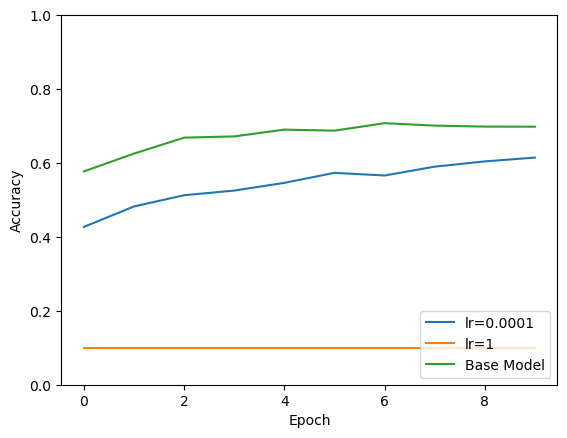

In [44]:
plt.plot(history3.history['val_accuracy'], label='lr=0.0001')
plt.plot(history31.history['val_accuracy'], label='lr=1')
plt.plot(history.history['val_accuracy'], label = 'Base Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss31, test_acc31 = model3.evaluate(test_images,  test_labels, verbose=2)

In [45]:
print(f'lr=0.0001 Model Accuracy --> {test_acc3:.2f}%\nlr=1 Model Accuracy --> {test_acc31:.2f}%\nBase Model Accuracy --> {test_acc:.2f}%')

lr=0.0001 Model Accuracy --> 0.61%
lr=1 Model Accuracy --> 0.10%
Base Model Accuracy --> 0.70%


References:
- https://www.tensorflow.org/tutorials/images/cnn
- https://www.tensorflow.org/tutorials/quickstart/advanced